# Statistical tests on the ASCAD Database

Contains:
- Normality tests
- Mean and variance

In [13]:
import numpy as np
import seaborn as sns

from statsmodels.stats.diagnostic import lilliefors
from tqdm import tqdm

from src.data.ascad import AscadRandomKey, TraceCategory
from src.tools.cache import cache_np

sns.set_style("whitegrid")

In [14]:
ascad = AscadRandomKey()

In [15]:
a = ascad.default.profile.filter_by_key(0) + 128

a.shape[1]

1400

### Lilliefors test for normality

If the $p$-value is lower than some threshold, e.g. $0.05$, then we can reject the $H_0$: the sample points are normally
distributed.

In [16]:
# p-value for Lilliefors test
LIL_P_VALUE = .05

100%|██████████| 256/256 [02:51<00:00,  1.49it/s]


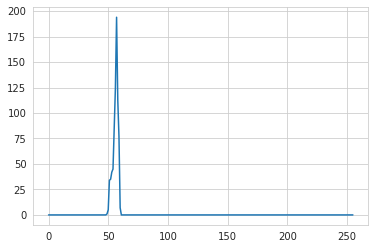

In [17]:
def normality(tc: TraceCategory, p_value=LIL_P_VALUE):
    """
    Tests the normality of all sample points from a TraceCategory for each first key byte.
    """
    res = []
    for k in tqdm(range(256)):
        key = np.moveaxis(tc.filter_by_key(k), 0, -1) + 128

        if k == 0:
            # Plot the 50th sample point distribution of the first key.
            g = sns.lineplot(data=np.bincount(key[50], minlength=256))

        pvs = np.array([lilliefors(sp, dist='norm')[1] for sp in key])
        res.append(np.sum(pvs > p_value))

    return res

norm_ps = cache_np("ascad_key/lil_norm", normality, ascad.default.profile)

In [18]:
print(f"{sum(norm_ps)} out of {1400 * 256} sample point distributions are likely to be normally "
      f"distributed.")

59 out of 358400 sample point distributions are likely to be normally distributed.


### Statistical properties of ASCAD

Average mean for first key.

In [19]:
ascad.default.profile.filter_by_key(0).mean(axis=0).mean()

-63.59426973684211

Average standard deviation for first key.

In [20]:
ascad.default.profile.filter_by_key(0).std(axis=0).mean()

2.274456188645743

## Experiments

### Normality and sliding window

Can we improve on normality by taking a sliding window over the sample points?

In [21]:
sw_size = 2
sw = np.empty((a.shape[0], a.shape[1]))

def pad_a(i, sliding_window_size):
    return np.pad(a, ((0,0), (i, sliding_window_size - i - 1)), 'constant', constant_values=np.nan)

pad_raw = np.array([pad_a(i, sw_size) for i in range(sw_size)])

mv_a = np.moveaxis(a, 0, -1)
mv_sw = np.moveaxis(pad_raw.reshape(-1, pad_raw.shape[-1]), 0, -1)

In [22]:
mv_sw.shape

(1401, 1520)

### Result after using a sliding window

Slightly more normally distributed.

<AxesSubplot:>

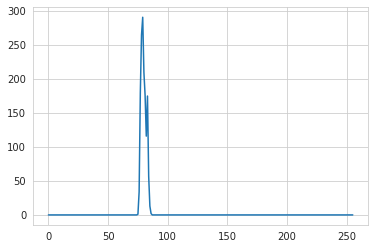

In [23]:
sns.lineplot(data=np.bincount(mv_sw[5:1400][2], minlength=256))

In [ ]:
sns.lineplot(data=np.array([lilliefors(sp, dist='norm')[1] for sp in mv_a]))